# Cluster Data Wrangling 

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from pydataset import data

import wrangle as w


import warnings
warnings.filterwarnings("ignore")


<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

### Zillow
For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

You will have a zillow.ipynb file and a helper file for each section in the pipeline.

#### acquire & summarize
1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

2. Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.
Only include properties that include a latitude and longitude value.
Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [2]:
# set and use zillow color palette
zpalette = ['#1277e1', '#f3ad35', '#0b449c', '#5289e4', '#c3eafb']
sns.set_palette(zpalette)
sns.color_palette()

[(0.07058823529411765, 0.4666666666666667, 0.8823529411764706),
 (0.9529411764705882, 0.6784313725490196, 0.20784313725490197),
 (0.043137254901960784, 0.26666666666666666, 0.611764705882353),
 (0.3215686274509804, 0.5372549019607843, 0.8941176470588236),
 (0.7647058823529411, 0.9176470588235294, 0.984313725490196)]

In [8]:
from env import host, password, user
import os

###################### Getting database Url ################
def get_db_url(db_name, user=user, host=host, password=password):
    """
        This helper function takes as default the user host and password from the env file.
        You must input the database name. It returns the appropriate URL to use in connecting to a database.
    """
    url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'
    return url

######################### get generic data #########################
def get_any_data(database, sql_query):
    '''
    put in the query and the database and get the data you need in a dataframe
    '''

    return pd.read_sql(sql_query, get_db_url(database))

######################### get Zillow Data #########################
def get_zillow_data():
    '''
    This function reads in Zillow data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    sql_query = """
                SELECT parcelid, airconditioningtypeid, airconditioningdesc, architecturalstyletypeid, architecturalstyledesc,
                bathroomcnt, bedroomcnt, buildingclasstypeid, buildingclassdesc, buildingqualitytypeid,
                decktypeid, calculatedfinishedsquarefeet, fips, fireplacecnt, fireplaceflag, garagecarcnt, garagetotalsqft,
                hashottuborspa, latitude, longitude, lotsizesquarefeet, poolcnt, poolsizesum, propertycountylandusecode,
                propertylandusetypeid, propertylandusedesc, propertyzoningdesc, rawcensustractandblock, 
                regionidcity, regionidcounty, regionidneighborhood, roomcnt, threequarterbathnbr, typeconstructiontypeid, typeconstructiondesc, unitcnt, yearbuilt, numberofstories, structuretaxvaluedollarcnt, taxvaluedollarcnt, assessmentyear, 
                landtaxvaluedollarcnt, taxamount, censustractandblock, logerror, transactiondate 
                FROM properties_2017 AS p
                JOIN predictions_2017 USING (parcelid)
                INNER JOIN (SELECT parcelid, MAX(transactiondate) AS transactiondate
                FROM predictions_2017
                GROUP BY parcelid) 
                AS t USING (parcelid, transactiondate)
                LEFT JOIN airconditioningtype USING (airconditioningtypeid)
                LEFT JOIN architecturalstyletype USING (architecturalstyletypeid)
                LEFT JOIN buildingclasstype USING (buildingclasstypeid)
                LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
                LEFT JOIN propertylandusetype USING (propertylandusetypeid)
                LEFT JOIN storytype USING (storytypeid)
                LEFT JOIN typeconstructiontype USING (typeconstructiontypeid)
                WHERE latitude IS NOT NULL AND longitude IS NOT NULL 
                AND transactiondate LIKE "2017%%";
                """
    if os.path.isfile('zillow_data.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow_data.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = pd.read_sql(sql_query, get_db_url('zillow'))
        
        # Cache data
        df.to_csv('zillow_data.csv')

    return df

In [9]:
# get the data using function
df = get_zillow_data()

In [12]:
# shape  of dataframe
df.shape

(77380, 46)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77380 non-null  int64  
 1   airconditioningtypeid         24953 non-null  float64
 2   airconditioningdesc           24953 non-null  object 
 3   architecturalstyletypeid      206 non-null    float64
 4   architecturalstyledesc        206 non-null    object 
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingclassdesc             15 non-null     object 
 9   buildingqualitytypeid         49671 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  calculatedfinishedsquarefeet  77184 non-null  float64
 12  fips                          77380 non-null  float64
 13  f

In [36]:
def count_object_values(df):
    
    obj_cols = [col for col in df.columns if df[col].dtype == 'object']
    
    for col in obj_cols:
        print(f'------{col}-------')
        print(df[col].value_counts())

In [49]:
def count_vals_less_10(df):
    
    small_cols = [col for col in df.columns if df[col].nunique() < 10]
    
    for col in small_cols:
        print(f'------{col}-------')
        print(df[col].value_counts())
        print(f'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [66]:
def count_unique(df):
    columns = df.columns
    
    for col in columns:
        print(f'{col} unique values\n{df[col].nunique()}\n================ ')

In [88]:
def overview(df, thresh = 10):
    '''
    This function takes in a dataframe and prints out useful things about each column.
    Unique values, value counts for columns less than 10 (can be adjusted with optional arguement thresh)
    Whether or not the row has nulls
    '''
    # create list of columns
    col_list = df.columns
    
    # loop through column list
    for col in col_list:
        # seperator using column name
        print(f'============== {col} ==============')
        
        # print out unique values for each column
        print(f'# Unique Vals: {df[col].nunique()}')
        
        # if number of things is under or equal to the threshold  print a value counts
        if df[col].nunique() <= thresh:
            print(df[col].value_counts(dropna = False).sort_index(ascending = True))
            
        # if the number is less than 150 and not an object, bin it and do value counts
        elif (df[col].nunique() < 150) and df[col].dtype != 'object' :
            print(df[col].value_counts(bins = 10, dropna=False).sort_index(ascending = True))
        
        # Space for readability 
        print('')
       

In [89]:
overview(df, thresh = 23) 

============== parcelid ==============
# Unique Vals: 77380

============== airconditioningtypeid ==============
# Unique Vals: 5
1.0     23133
5.0       167
9.0        26
11.0       53
13.0     1574
NaN     52427
Name: airconditioningtypeid, dtype: int64

============== airconditioningdesc ==============
# Unique Vals: 5
Central          23133
None               167
Refrigeration       26
Wall Unit           53
Yes               1574
NaN              52427
Name: airconditioningdesc, dtype: int64

============== architecturalstyletypeid ==============
# Unique Vals: 5
2.0         5
3.0         3
7.0       172
8.0        19
21.0        7
NaN     77174
Name: architecturalstyletypeid, dtype: int64

============== architecturalstyledesc ==============
# Unique Vals: 5
Bungalow             5
Cape Cod             3
Contemporary       172
Conventional        19
Ranch/Rambler        7
NaN              77174
Name: architecturalstyledesc, dtype: int64

============== bathroomcnt ==============
#

#### Takeaways
- not sure what roomcnt is and how it's different from bedrooms and bathrooms 
- three quarter bath seems redundant 
- most of the homes here are single family 
- there's someone who has a 14 car garage (maybe it's a quadruplex or something)
- three houses have 5 fireplaces. Must be really cold there in Southern California
- Date could be changed to a datetime object

In [119]:
def plot_variable_dist(df, figsize = (3,2)):
    '''
    This function is for exploring. Takes in a dataframe with variables you would like to see the distribution of.
    Input the dataframe (either fully, or using .drop) with ONLY the columns you want to see plotted.
    Optional arguement figsize. Default it's small. 
    BTW if you just put list(df) it pulls out only the column names
    '''
    # create list of columns with numeric values
    num_col = [col for col in list(df) if df[col].dtype != 'O']
    
    # loop through columns and use seaborn to plot distributions
    for col in num_col:
        plt.figure(figsize=figsize)
        sns.histplot(data = df, x = col, kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

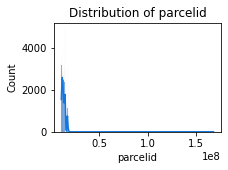

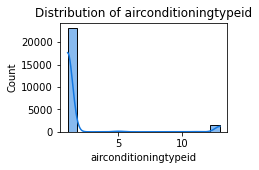

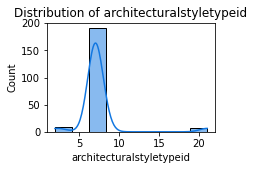

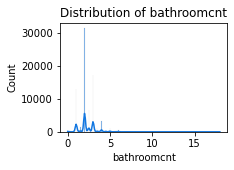

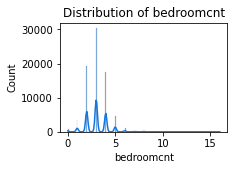

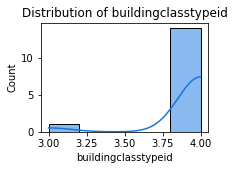

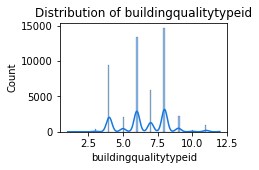

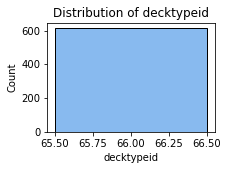

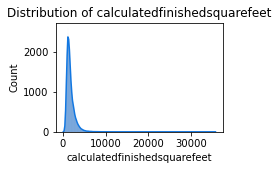

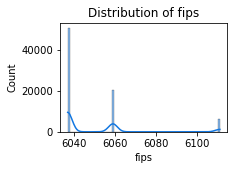

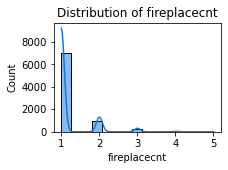

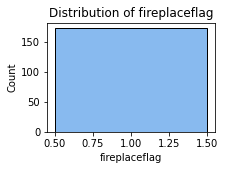

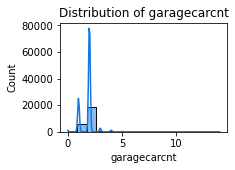

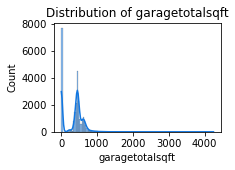

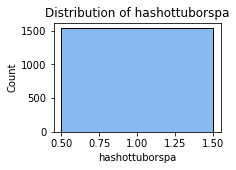

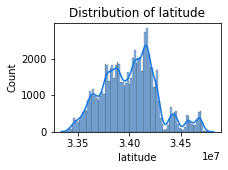

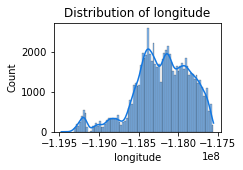

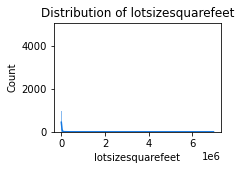

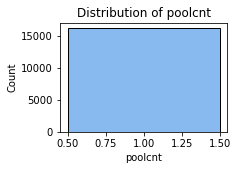

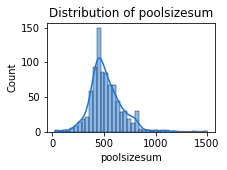

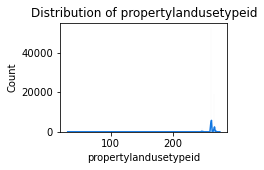

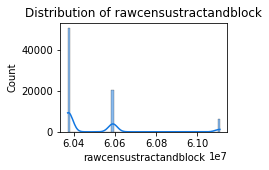

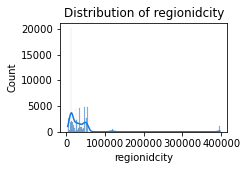

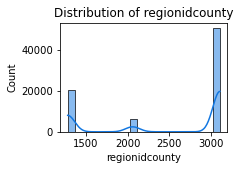

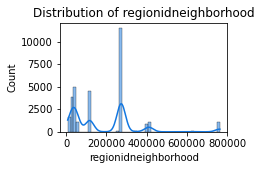

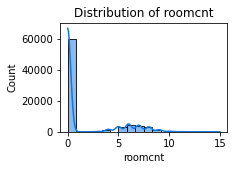

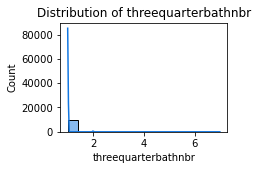

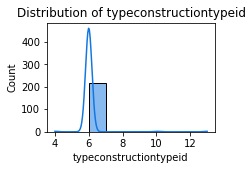

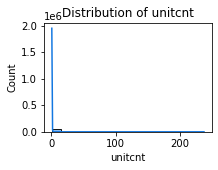

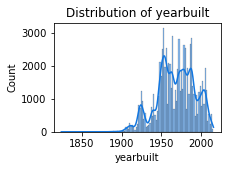

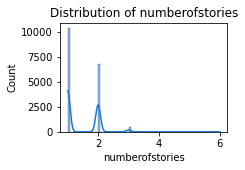

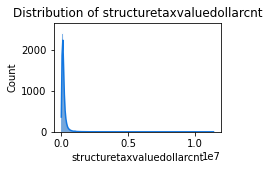

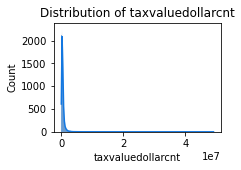

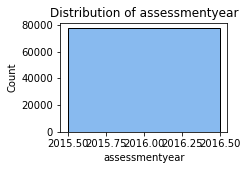

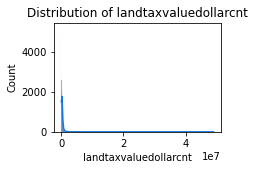

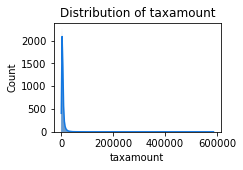

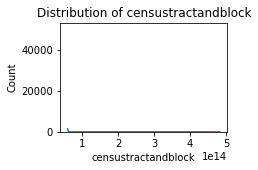

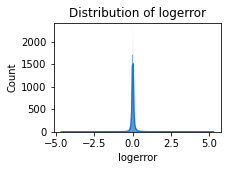

In [120]:
plot_variable_dist(df)


3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.


In [15]:
# I saw this on the afore mentioned kaggle site. This is the credit that author gave.
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
    '''
    this function takes a dataframe as input and will output metrics for missing values, 
    and the percent of that column that has missing values
    '''
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")
        
        # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [16]:
missing_values_table(df)

Your selected dataframe has 46 columns.
There are 31 columns that have missing values.


,Missing Values,% of Total Values
buildingclasstypeid,77365,100.0
buildingclassdesc,77365,100.0
fireplaceflag,77208,99.8
architecturalstyletypeid,77174,99.7
architecturalstyledesc,77174,99.7
typeconstructiondesc,77158,99.7
typeconstructiontypeid,77158,99.7
decktypeid,76766,99.2
poolsizesum,76513,98.9
hashottuborspa,75842,98.0


#### Takeaways
- buildingclassdesc and buildingclasstypeid have too many missing, will drop
- fireplaceflag seems to not have been used as much as fireplacecnt (drop fireplaceflag)
- the architectural columns also don't have enough to go on, nothing to replace with
- typeconstructiondesc and typeconstructiontypeid both don't have enough values (these are things like concrete, masonry) 
- decktypeid, poolsizesum, 
- numberofstories doesn't seem like something would be a driver of price 

Turned to 0s 
- hashottuborspa Nan's could be turned to 0s 
- fireplacecnt 
- garagecarcnt can have NaN's converted to 0s 


<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

1. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [83]:
# number of rows | missing 6 |out of 46 columns so that's x percent

def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = round(num_missing / df.shape[1] * 100, 2)
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing


In [84]:
nulls_by_row(df)

,num_cols_missing,percent_cols_missing,num_rows
0,9,19.57,2
1,10,21.74,10
2,11,23.91,23
3,12,26.09,62
4,13,28.26,114
5,14,30.43,416
6,15,32.61,5577
7,16,34.78,10549
8,17,36.96,14385
9,18,39.13,21032


<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

#### Prepare
1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.
    - looked up definitions, included single family residential, condo, mobile home, townhouse 


In [91]:
df.propertylandusedesc.value_counts(dropna = False).to_frame()

,propertylandusedesc
Single Family Residential,52319
Condominium,19294
"Duplex (2 Units, Any Combination)",2009
Planned Unit Development,1944
"Quadruplex (4 Units, Any Combination)",727
"Triplex (3 Units, Any Combination)",535
Cluster Home,333
Mobile Home,74
"Manufactured, Modular, Prefabricated Homes",58
Residential General,37


In [137]:
# keep single family residential, condomininum, manufactured modualr prefabricated homes, townhouse 
# drop if unit count 2 or higher 
single_homes = ['Single Family Residential', 'Condominium', 'Townhouse', 'Manufactured, Modular, Prefabricated Homes', 'Mobile Home']
df[df['propertylandusedesc'].isin(single_homes)].propertylandusedesc.value_counts()

Single Family Residential                     52319
Condominium                                   19294
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       58
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

In [105]:
# end result will be the first two groups together
df[df['propertylandusedesc'].isin(single_homes)].unitcnt.value_counts(dropna=False)

1.0    45233
NaN    26408
2.0       32
3.0        3
6.0        1
Name: unitcnt, dtype: int64

In [110]:
df[df['unitcnt'] == 1].propertylandusedesc.value_counts(dropna=False)

Single Family Residential                   33733
Condominium                                 11494
Planned Unit Development                     1937
Mobile Home                                    53
Cooperative                                    29
Duplex (2 Units, Any Combination)              20
Residential General                            10
Commercial/Office/Residential Mixed Used        8
Townhouse                                       6
Triplex (3 Units, Any Combination)              2
Name: propertylandusedesc, dtype: int64

In [111]:
missing_vals = missing_values_table(df)

Your selected dataframe has 46 columns.
There are 31 columns that have missing values.


In [147]:
# goal: keep all houses that are in the single_homes list i made up and that have a unit count of 1 or nan
print(f'shape before {df.shape}')
after_shape = df[df['propertylandusedesc'].isin(single_homes)].shape
print(f'shape after {after_shape}')

shape before (77380, 46)
shape after (71751, 46)


In [148]:
new_df = df[df['propertylandusedesc'].isin(single_homes)]

In [182]:
# create mask if unit count is 1 or NaN
unitcnt_mask = (new_df['unitcnt'] == 1) | (new_df['unitcnt'].isnull())

In [183]:
new_df[unitcnt_mask].shape

(71715, 46)

In [187]:
# put in wrangle function
def single_homes(df):
    '''
    Function takes in zillow dataframe and outputs dataframe with only data for single unit homes.
    Single unit home defined as any of the following 
    'Single Family Residential', 'Condominium', 'Townhouse', 'Manufactured, Modular, Prefabricated Homes', 'Mobile Home'
    Home must also have unit count of 1 or NaN
    '''
    # define single home descriptions
    single_homes = ['Single Family Residential', 'Condominium', 'Townhouse', 'Manufactured, Modular, Prefabricated Homes', 'Mobile Home']
    
    # If the property land use description is the in the single homes list keep it
    df = df[df['propertylandusedesc'].isin(single_homes)]
    
    # create mask if unit count is 1 or NaN
    unitcnt_mask = (df['unitcnt'] == 1) | (df['unitcnt'].isnull())
    
    # apply mask to dataframe
    df = df[unitcnt_mask]
    
    return df
    

In [314]:
new_df = single_homes(df)

In [219]:
# should have shape of 71715
new_df.shape

(71715, 46)

In [190]:
new_df.unitcnt.value_counts(dropna=False)

1.0    45286
NaN    26429
Name: unitcnt, dtype: int64

In [191]:
missing_values_table(new_df)

Your selected dataframe has 46 columns.
There are 31 columns that have missing values.


,Missing Values,% of Total Values
buildingclasstypeid,71715,100.0
buildingclassdesc,71715,100.0
fireplaceflag,71543,99.8
architecturalstyletypeid,71509,99.7
architecturalstyledesc,71509,99.7
typeconstructiondesc,71493,99.7
typeconstructiontypeid,71493,99.7
decktypeid,71125,99.2
poolsizesum,70848,98.8
hashottuborspa,70178,97.9


In [192]:
# propbably drop this because a better value of the place is whether or not they have parking
# not a data point in this
new_df.garagecarcnt.value_counts(dropna=False)

NaN     46755
2.0     18389
1.0      5536
3.0       632
4.0       255
0.0        75
5.0        45
6.0        14
7.0         4
10.0        3
8.0         2
9.0         2
14.0        1
11.0        1
13.0        1
Name: garagecarcnt, dtype: int64

In [195]:
def pool_party(df):
    '''
    This function fixes the NaNs in the pool column and fills them with 0s.
    Essentially turning this into a has_pool column
    '''
    df['poolcnt'] = df.poolcnt.fillna(value=0)

    return df

In [315]:
new_df = pool_party(new_df)

In [225]:
def unitcnt_filler(df):
    '''
    Function fills in nans in the unit count because we're only dealing with single family homes now
    '''
    df['unitcnt'] = df.unitcnt.fillna(value=1)
    
    return df

In [316]:
new_df = unitcnt_filler(new_df)

2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

- The input:
    - A dataframe
    - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
    - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
- The output:
    - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
- hint:
    - Look up the dropna documentation.
    - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
    - Make use of inplace, i.e. inplace=True/False.


In [307]:
nulls_by_row(new_df)

,num_cols_missing,percent_cols_missing,num_rows
0,8,17.39,2
1,9,19.57,12
2,10,21.74,30
3,11,23.91,71
4,12,26.09,177
5,13,28.26,634
6,14,30.43,1642
7,15,32.61,13453
8,16,34.78,16021
9,17,36.96,20290


In [213]:
int(round((new_df.shape[1] *.75)))

34

In [317]:
# put in wrangle
# threshold originally at 50
# raised to 65 took care of the need for the function below 
def drop_missing(df, min_col_percent= 0.75, min_row_percent = 0.75):
    '''
    This columns takes in a dataframe and outputs one with nulls dropped
    The minimum col percent is how many null values you would like to have in your columns for them to stay
    min_row_percent will be how many values must be not null in order to keep that row
    '''
    # calculate columns threshold (any columsn that have more nulls than this, dropped)
    col_thresh = int(round(min_col_percent*df.shape[0]))
    
    # drop coulmns 
    df = df.dropna(axis=1, thresh=col_thresh)
    
    # calculate row threshold 
    row_thresh = int(round(min_row_percent * df.shape[1]))
    
    # drop rows
    
    df = df.dropna(axis=0, thresh=row_thresh)
    
    return df

In [318]:
new_df = drop_missing(new_df)

In [319]:
missing_values_table(new_df)

Your selected dataframe has 26 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
lotsizesquarefeet,7888,11.1
regionidcity,1287,1.8


In [284]:
percent_mask = ((new_df.isnull().sum() / new_df.shape[0]) < .01)

percent_mask[percent_mask == True].index

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'latitude', 'longitude', 'poolcnt', 'propertycountylandusecode',
       'propertylandusetypeid', 'propertylandusedesc',
       'rawcensustractandblock', 'regionidcounty', 'roomcnt', 'unitcnt',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount',
       'censustractandblock', 'logerror', 'transactiondate'],
      dtype='object')

In [280]:
    lis =((100 * df.isnull().sum() / len(df))> 0) &  ((100 * df.isnull().sum() / len(df))< 1)
    col_drop = list(lis[lis == True].index)
    df = df.dropna(axis=0, subset = col_drop)

In [15]:
# still have some nulls down at the bottom. Drop those rows with less than a percent missing. 
# put in wrangle
def drop_rows_low_percent(df):
    '''
    Finds columns with missing values less than 1 percent. Drops all rows with missing values in those rows.
    '''
    
    has_percent_below_one = ((df.isnull().sum() / df.shape[0]) < .01)
    
    one_percenters = list(has_percent_below_one[has_percent_below_one == True].index)
    
    df = df.dropna(axis=0, subset=one_percenters)
    
    return df

In [311]:
new_df1 = drop_rows_low_percent(new_df)

In [312]:
missing_values_table(new_df1)

Your selected dataframe has 26 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
lotsizesquarefeet,7888,11.1
regionidcity,1287,1.8


In [320]:
new_df.shape

(71238, 26)

In [324]:
# only rows left with Nans are lotsizesquarefeet and regionidcity
# regionidcity should be captured in long and lat DROP COLUMN
# lotsizesquarefeet might not have impact on error. DROP FOR NOW. MAYBY IMPUTE LATER

new_df = new_df.drop(columns = ['lotsizesquarefeet', 'regionidcity'])

In [16]:
def drop_unneeded_cols(df, unneeded_cols = ['lotsizesquarefeet', 'regionidcity']):
    '''
    This function takes in a dataframe and a list of unneeded columns (default is for zillow data)
    Returns dataframe with those columns dropped
    '''
    df = df.drop(columns = unneeded_cols)
    
    return df

3. Decide how to handle the remaining missing values:
    - Fill with constant value.
    - Impute with mean, median, mode.
    - Drop row/column



In [323]:
new_df.lotsizesquarefeet.describe()

count    6.335000e+04
mean     3.078310e+04
std      1.265990e+05
min      2.360000e+02
25%      5.855000e+03
50%      7.325500e+03
75%      1.240000e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64

In [5]:
def remove_outliers(df, k, col_list):
    '''
    This function takes in a dataframe, k value, and column list and 
    k = number times interquartile range you would like to remove
    col_list = names of columns you want outliers removed from
    removes outliers from a list of columns in a dataframe 
    and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[f'{col}'].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]
        
    return df

#### wrangle_zillow.py
Functions of the work above needed to acquire and prepare a new sample of data.

In [2]:
train, validate, test = w.wrangle_zillow()

train --> (39893, 25)
validate --> (17097, 25)
test --> (14248, 25)


In [3]:
w.missing_values_table(train)

Your selected dataframe has 25 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values
